In [119]:
import numpy as np
import math
import scipy.optimize as coolNonLinOptimizer
import cv2
import matplotlib.pyplot as plt

In [27]:
# Setup

R1 = np.identity(3)
R2 = np.identity(3)
t1 = np.array([0,0,1]).T
t2 = np.array([0,0,20]).T
K1 = np.array([[700,0,600],
              [0,700,400],
              [0,0,1]])
K2 = np.array([[700,0,600],
              [0,700,400],
              [0,0,1]])

Q = np.array([1,1,0]).T
Q_h = np.hstack([Q.T,1])
print(Qh)

[1 1 0 1]


In [30]:
# Exercise 5.1
intri1 = np.vstack([R1,t1]).T
print(intri1)
P1 = K1@(np.vstack([R1,t1]).T)
P2 = K2@(np.vstack([R2,t2]).T)
q1_h = P1@Q_h
q2_h = P2@Q_h
q1 = q1_h[:-1]/q1_h[-1]
q2 = q2_h[:-1]/q2_h[-1]
print('q1',q1)
print('q2',q2)




[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 1.]]
q1 [1300. 1100.]
q2 [635. 435.]


In [60]:
#Triangulate function
def triangulate(q, P):
    """
    Return the traingulation.
    
    Parameters
    ----------
    q: 2 x n numpy array
        INHomogenous pixel coordinates q1... qn
        One for each camera seeing the point.
        At least two.
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
        For each pixel coordinate
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear SVD algorithm
    """
    _, n = q.shape # n = no. cameras has seen pixel.
    # Prepare B matrix. Two rows for each camera n.
    B = np.zeros((2 * n, 4))
    for i in range(n):
        B[2 * i: 2 * i + 2] = [
            P[i][2, :] * q[0, i] - P[i][0, :],
            P[i][2, :] * q[1, i] - P[i][1, :],
        ]
    # BQ = 0. Minimize using Svd.
    _, _, vh = np.linalg.svd(B)
    Q = vh[-1, :] # Q is ev. corresponding to the min. singular point.
    return Q[:3].reshape(3, 1) / Q[3] # Reshape and scale.


In [64]:
#Exercise 5.2
q1_tilt = q1 + np.array([1,-1])
q2_tilt = q2 + np.array([1,-1])
q1_tilt_h = np.hstack([q1_tilt.T,1])
q2_tilt_h = np.hstack([q2_tilt.T,1])

Q_tilt = triangulate(np.array([q1_tilt_h.T,q2_tilt_h.T]).T,[P1,P2])
print('Q_tilt',Q_tilt)
Q_tilt_h = np.hstack([Q_tilt[:,0].T,1])
q1_re_h = P1@Q_tilt_h
q2_re_h = P2@Q_tilt_h
q1_re = q1_re_h[:-1]/q1_re_h[-1]
q2_re = q2_re_h[:-1]/q2_re_h[-1]
print('q1_re',q1_re)
print('q2_re',q2_re)



Q_tilt [[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]
q1_re [1310.48950027 1089.4923513 ]
q2_re [635.53411968 434.4839772 ]


In [67]:
# Exercse 5.3
def triangulate_nonlin(qs,Ps):
    Q0 = triangulate(qs,Ps)
    Q0 = Q0.reshape(3)
    def compute_residuals(Q):
        Q_h = np.hstack([Q,1])
        n = len(qs)
        residuals = np.zeros(shape=(2*n,))
        for i in range(n):
            q_est_h = Ps[i]@Q_h
            q_est = q_est_h[:-1]/q_est_h[-1]
            r = q_est - qs[:,i]
            residuals[2*i] = r[0]
            residuals[2*i+1] = r[1]
        return residuals
    Q = coolNonLinOptimizer.least_squares(compute_residuals, Q0)["x"]
            
    return Q


[1.00153898e+00 9.98546326e-01 4.27535402e-05]


In [68]:
# Exercise 5.4
Q_tilt_non = triangulate_nonlin(np.array([q1_tilt.T,q2_tilt.T]).T,[P1,P2])
print(Q_tilt_non)
    



[1.00153898e+00 9.98546326e-01 4.27535402e-05]


In [87]:
# Exercise 5.6 - Stolen from Henrik

def get_rgb(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    image = cv2.merge([r,g,b])
    return image



images = []
for i in range(20):
    image = get_rgb("/home/christian/notebook/checkerboards/c%02d.jpg" %i)
    image = cv2.resize(image, (600, 400))
    images.append(image)

imgpoints = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        imgpoints.append(corners)
        # Draw and display the corners
        #painted = cv2.drawChessboardCorners(img.copy(), (7, 10), corners,ret)
        #cv2.imshow('img',painted)
        #cv2.waitKey(400)

#cv2.destroyAllWindows()




In [84]:
# Exercise 5.7

def checkerboard_points(n,m):
    Q = np.zeros((3,n*m))
    for i in range(n):
        for j in range(m):
            Q[:,i*m+j] = np.array([i-((n-1)/2),j-((m-1)/2),0])
    return Q


In [122]:
def CrossOp(p):
    return np.array([[0,-p[2],p[1]],
                    [p[2],0,-p[0]],
                    [-p[1],p[0],0]])

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b_new(q1,q2) #np.vstack((B0,B1))
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (np.linalg.inv(T1)@H.T@T2.round(2))

def get_b_new(q1,q2):
    B = np.kron(q2[:,0], CrossOp(q1[:,0]))
    for i in range(1,len(q1.T)):
        B_temp = np.kron(q2[:,i], CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    return B

def get_b(q1,q2):
    B = np.kron(q2[:,0], CrossOp(q1[:,0]))
    for i in range(1,len(q1.T)):
        B_temp = np.kron(q2[:,i], CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    return B

def estimateHomographies(Q_omega,qs):
    Q_omega_mz = Q_omega[:-1]
    Qh_omega = np.vstack([Q_omega_mz, np.ones((1,len(Q_omega_mz.T)))])
    Hs = []
    for q in qs:
        qh = np.vstack([q,np.ones((1,len(q.T)))])
        Hs.append(hest(qh,Qh_omega))
    return Hs


def estimate_b(Hs):
    V = make_Vrow(Hs[0])
    for i in range(1,len(Hs)):
        V = np.vstack([V,make_Vrow(Hs[i])])
    U,S,VT = np.linalg.svd(V)
    b = VT[-1]
    return b
    
    
    
def make_Vrow(H):
    v12 = np.array([H[0,0]*H[0,1],H[0,0]*H[1,1]+H[1,0]*H[0,1],H[1,0]*H[1,1],
                   H[2,0]*H[0,1]+H[0,0]*H[2,1],H[2,0]*H[1,1]+H[1,0]*H[2,1],H[2,0]*H[2,1]])
    v11 = np.array([H[0,0]*H[0,0],H[0,0]*H[1,0]+H[1,0]*H[0,0],H[1,0]*H[1,0],
                   H[2,0]*H[0,0]+H[0,0]*H[2,0],H[2,0]*H[1,0]+H[1,0]*H[2,0],H[2,0]*H[2,0]])
    v22 = np.array([H[0,1]*H[0,1],H[0,1]*H[1,1]+H[1,1]*H[0,1],H[1,1]*H[1,1],
                   H[2,1]*H[0,1]+H[0,1]*H[2,1],H[2,1]*H[1,1]+H[1,1]*H[2,1],H[2,1]*H[2,1]])
    V = np.vstack([v12,v11-v22])
    return V
    


def estimateIntrinsics(Hs):
    b = estimate_b(Hs)
    v0 = (b[1]*b[3]-b[0]*b[4])/(b[0]*b[2]-b[1]**2)
    lamb = b[5]-((b[3]**2+v0*(b[1]*b[3]-b[0]*b[4]))/b[0])
    alpha = math.sqrt(lamb/b[0])
    beta = math.sqrt((lamb*b[0])/(b[0]*b[2]-b[1]**2))
    gamma = -b[1]*alpha**2*beta/lamb
    u0 = gamma*v0/beta - b[3]*alpha**2/lamb
    K = np.array([[alpha,gamma,u0],
                  [0,beta,v0],
                  [0,0,1]])
    return K

def estimateExtrinsics(K,Hs):
    ts = []
    Rs = []
    for H in Hs:
        lamb = np.linalg.norm(np.linalg.inv(K)*H[:,0],2)
        r1 = (1/lamb)*np.linalg.inv(K)@H[:,0]
        r2 = (1/lamb)*np.linalg.inv(K)@H[:,1]
        r3 = np.cross(r1,r2)
        ts.append((1/lamb)*np.linalg.inv(K)@H[:,2])
        Rs.append(np.vstack([r1,r2,r3]).T)

    ts = np.mean(ts,axis=0)    

    Rs = np.mean(Rs,axis=0)
    return Rs, ts


def calibratecamera(qs,Q):
    Hs = estimateHomographies(Q,qs)
    K = estimateIntrinsics(Hs)
    Rs, ts = estimateExtrinsics(K,Hs)
    return K, Rs, ts




In [101]:
qs = []
for i in range(len(imgpoints)):    
    r, _, c = imgpoints[i].shape
    q_ = np.zeros(shape=(c, r))
    q_[0, :] = imgpoints[i][:,0,0]
    q_[1, :] = imgpoints[i][:,0,1]
    qs.append(q_)


In [123]:
checker_points = checkerboard_points(10,7)

K_self,Rs_self,ts_self = calibratecamera(qs,checker_points)

print('K',K_self)
print('Rs',Rs_self)
print('ts',ts_self)

K [[693.37827726 142.6841463  478.82978242]
 [  0.         564.80927065 194.24722869]
 [  0.           0.           1.        ]]
Rs [[-0.78940069 -0.20670512 -0.22709828]
 [-0.05527703  0.64571298 -0.84246572]
 [ 0.30976227 -0.6177531  -1.02791035]]
ts [-4.81933723 -0.49371287 17.37224631]


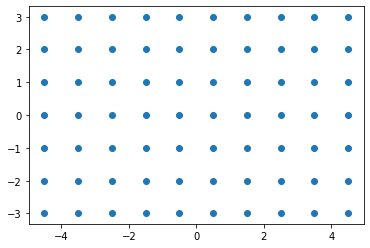

In [121]:
plt.scatter(checker_points[0,:], checker_points[1,:])
